In [2]:
import numpy as np
import pandas as pd

In [3]:
data1 = pd.read_csv(r"D:\Y4 Research\datasets\DSLD-full-database-CSV\DSLD-full-database-CSV\DietarySupplementFacts_1.csv",
                 encoding="latin1")

In [4]:
data1

,URL,DSLD ID,Product Name,Serving Size,Ingredient,DSLD Ingredient Categories,Amount Per Serving,Amount Per Serving Unit,% Daily Value per Serving,Daily Value Target Group
0,https://dsld.od.nih.gov/label/542,542,B-2 100 mg,1 Tablet(s),Riboflavin,vitamin,100,mg,5882,Adults and children 4 or more years of age
1,https://dsld.od.nih.gov/label/543,543,B-6 100 mg,1 Tablet(s),Vitamin B6,vitamin,100,mg,5000,Adults and children 4 or more years of age
2,https://dsld.od.nih.gov/label/544,544,C-1000 mg With Protective Bioflavonoids And Wi...,1 Caplet(s),Vitamin C,vitamin,1000,mg,1667,Adults and children 4 or more years of age
3,https://dsld.od.nih.gov/label/544,544,C-1000 mg With Protective Bioflavonoids And Wi...,1 Caplet(s),Citrus Bioflavonoids,non-nutrient/non-botanical,25,mg,NaN,Adults and children 4 or more years of age
4,https://dsld.od.nih.gov/label/544,544,C-1000 mg With Protective Bioflavonoids And Wi...,1 Caplet(s),Rose Hips,botanical,20,mg,NaN,Adults and children 4 or more years of age
...,...,...,...,...,...,...,...,...,...,...
301874,https://dsld.od.nih.gov/label/31483,31483,Assault Fruit Punch,14.5 Gram(s),Huperzine A,non-nutrient/non-botanical,NaN,NaN,NaN,NaN
301875,https://dsld.od.nih.gov/label/31483,31483,Assault Fruit Punch,14.5 Gram(s),Hydration System,blend,1200,mg,NaN,Adults and children 4 or more years of age
301876,https://dsld.od.nih.gov/label/31483,31483,Assault Fruit Punch,14.5 Gram(s),Taurine,non-nutrient/non-botanical,NaN,NaN,NaN,NaN
301877,https://dsld.od.nih.gov/label/31483,31483,Assault Fruit Punch,14.5 Gram(s),Coconut Water Powder,botanical,NaN,NaN,NaN,NaN


Exploring Data Set

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301879 entries, 0 to 301878
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   URL                         301879 non-null  object
 1   DSLD ID                     301879 non-null  int64 
 2   Product Name                301879 non-null  object
 3   Serving Size                301879 non-null  object
 4   Ingredient                  301879 non-null  object
 5   DSLD Ingredient Categories  301879 non-null  object
 6   Amount Per Serving          235162 non-null  object
 7   Amount Per Serving Unit     241366 non-null  object
 8   % Daily Value per Serving   124364 non-null  object
 9   Daily Value Target Group    228974 non-null  object
dtypes: int64(1), object(9)
memory usage: 23.0+ MB


In [6]:
data1.isnull().sum()

URL                                0
DSLD ID                            0
Product Name                       0
Serving Size                       0
Ingredient                         0
DSLD Ingredient Categories         0
Amount Per Serving             66717
Amount Per Serving Unit        60513
% Daily Value per Serving     177515
Daily Value Target Group       72905
dtype: int64

In [5]:
import cv2
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

Found 19 PNG images in the directory

First few image names:
  - 542 conv 0.png
  - 543 conv 0.png
  - 544 conv 0.png
  - 545 conv 0.png
  - 546 conv 0.png


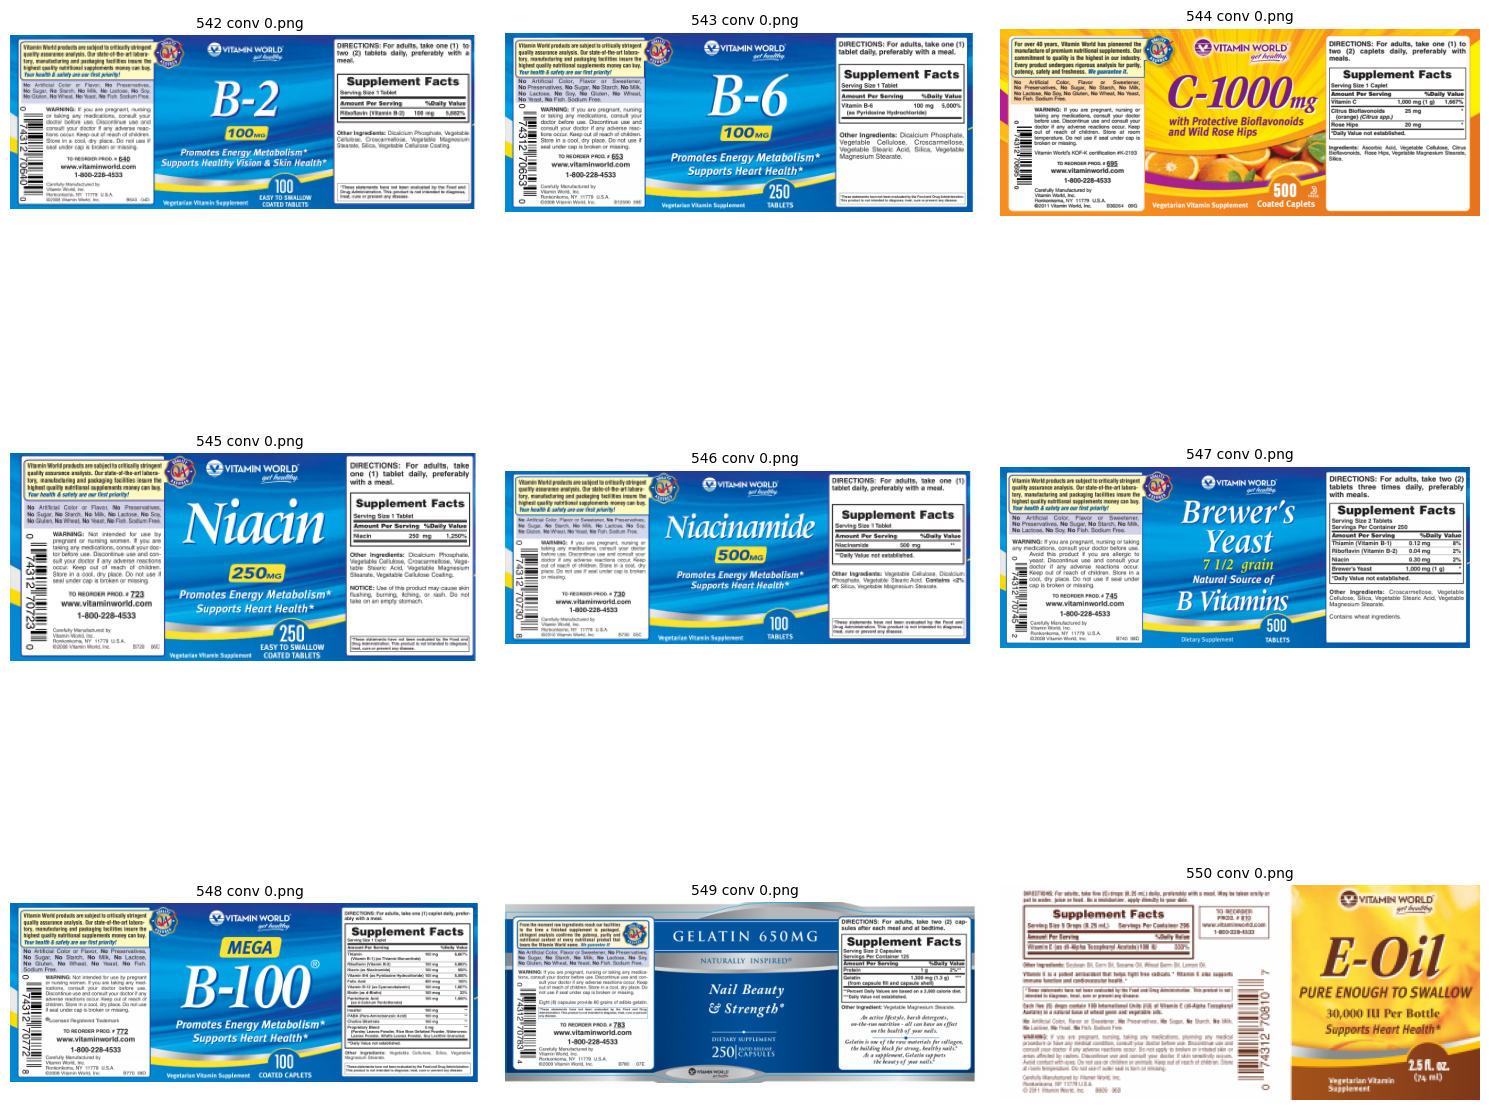

In [3]:
# Set the path to your images directory
image_dir = r"D:\Y4 Research\datasets\Images\Set1"

# Get all PNG files from the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

print(f"Found {len(image_files)} PNG images in the directory")

# Display basic information about the dataset
if image_files:
    print(f"\nFirst few image names:")
    for img_name in image_files[:5]:
        print(f"  - {img_name}")

# Function to display a grid of images
def display_images(image_dir, image_files, num_images=9, figsize=(15, 15)):
    """
    Display a grid of images from the dataset
    
    Parameters:
    - image_dir: directory path
    - image_files: list of image filenames
    - num_images: number of images to display (default: 9)
    - figsize: figure size for the plot
    """
    num_images = min(num_images, len(image_files))
    cols = 3
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i in range(num_images):
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(image_files[i], fontsize=10)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first 9 images
if image_files:
    display_images(image_dir, image_files, num_images=9)

In [6]:
from pathlib import Path

def resize_with_aspect_ratio(img, target_size=1024):
    h, w = img.shape[:2]

    # scaling factor to fit largest side
    scale = target_size / max(h, w)

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(img, (new_w, new_h))

    # create padded square canvas (black padding)
    canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # paste resized image onto canvas (top-left)
    canvas[0:new_h, 0:new_w] = resized

    return canvas


# Input and Output directories
input_dir = r"D:\Y4 Research\datasets\Images\Set1"
output_dir = r"D:\Y4 Research\datasets\Images\Set1_Normalized"

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all PNG images in input directory
for filename in os.listdir(input_dir):

    # Only process PNG files
    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)

    img = cv2.imread(img_path)
    if img is None:
        print(f"Skipping (cannot read): {filename}")
        continue

    # Normalize image (resize + pad)
    out = resize_with_aspect_ratio(img, 1024)

    # Remove original extension and add .png
    base_name = Path(filename).stem
    save_path = os.path.join(output_dir, base_name + ".png")

    # Save as PNG
    cv2.imwrite(save_path, out)

    print(f"Processed: {filename}")

print("All PNG images processed successfully!")

Processed: 542 conv 0.png
Processed: 543 conv 0.png
Processed: 544 conv 0.png
Processed: 545 conv 0.png
Processed: 546 conv 0.png
Processed: 547 conv 0.png
Processed: 548 conv 0.png
Processed: 549 conv 0.png
Processed: 550 conv 0.png
Processed: 551 conv 0.png
Processed: 552 conv 0.png
Processed: 553 conv 0.png
Processed: 554 conv 0.png
Processed: 555 conv 0.png
Processed: 556 conv 0.png
Processed: 557 conv 0.png
Processed: 558 conv 0.png
Processed: 559 conv 0.png
Processed: 560 conv 0.png
All PNG images processed successfully!


In [7]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    corrected = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return corrected


# ------------------------------
# Shadow removal (morphological method)
# ------------------------------
def remove_shadows(img):
    rgb_planes = cv2.split(img)
    result_planes = []

    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((25,25), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 25)

        diff = 255 - cv2.absdiff(plane, bg_img)

        norm = cv2.normalize(diff, None, alpha=0, beta=255,
                             norm_type=cv2.NORM_MINMAX)
        result_planes.append(norm)

    result = cv2.merge(result_planes)
    return result


# ------------------------------
# Paths
# ------------------------------
input_dir = r"D:\Y4 Research\datasets\Images\Set1_Normalized"
output_dir = r"D:\Y4 Research\datasets\Images\Set1_IlluminationCorrected"

os.makedirs(output_dir, exist_ok=True)


# ------------------------------
# Processing loop
# ------------------------------
for filename in os.listdir(input_dir):

    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Cannot read: {filename}")
        continue

    # Apply illumination correction
    img_clahe = apply_clahe(img)
    img_final = remove_shadows(img_clahe)

    # Save output PNG
    base = Path(filename).stem
    save_path = os.path.join(output_dir, base + ".png")
    cv2.imwrite(save_path, img_final)

    print(f"Processed: {filename}")


print("All illumination-corrected images saved successfully!")

Processed: 542 conv 0.png
Processed: 543 conv 0.png
Processed: 544 conv 0.png
Processed: 545 conv 0.png
Processed: 546 conv 0.png
Processed: 547 conv 0.png
Processed: 548 conv 0.png
Processed: 549 conv 0.png
Processed: 550 conv 0.png
Processed: 551 conv 0.png
Processed: 552 conv 0.png
Processed: 553 conv 0.png
Processed: 554 conv 0.png
Processed: 555 conv 0.png
Processed: 556 conv 0.png
Processed: 557 conv 0.png
Processed: 558 conv 0.png
Processed: 559 conv 0.png
Processed: 560 conv 0.png
All illumination-corrected images saved successfully!


In [8]:
def denoise_image(img):

    # 1. Median blur (removes salt & pepper noise)
    median = cv2.medianBlur(img, 3)

    # 2. Bilateral filter (smooth noise + preserve edges)
    bilateral = cv2.bilateralFilter(median, d=9, sigmaColor=75, sigmaSpace=75)

    return bilateral


# ---------------------------------------
# Paths
# ---------------------------------------
input_dir = r"D:\Y4 Research\datasets\Images\Set1_IlluminationCorrected"
output_dir = r"D:\Y4 Research\datasets\Images\Set1_Denoised"

os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------
# Processing Loop
# ---------------------------------------
for filename in os.listdir(input_dir):

    # Only PNG images
    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    file_path = os.path.join(input_dir, filename)
    img = cv2.imread(file_path)

    if img is None:
        print(f"Cannot read file: {filename}")
        continue

    # Apply noise removal
    clean = denoise_image(img)

    # Save image
    base_name = Path(filename).stem
    save_path = os.path.join(output_dir, base_name + ".png")
    cv2.imwrite(save_path, clean)

    print(f"Processed: {filename}")

print("All denoised images saved successfully!")

Processed: 542 conv 0.png
Processed: 543 conv 0.png
Processed: 544 conv 0.png
Processed: 545 conv 0.png
Processed: 546 conv 0.png
Processed: 547 conv 0.png
Processed: 548 conv 0.png
Processed: 549 conv 0.png
Processed: 550 conv 0.png
Processed: 551 conv 0.png
Processed: 552 conv 0.png
Processed: 553 conv 0.png
Processed: 554 conv 0.png
Processed: 555 conv 0.png
Processed: 556 conv 0.png
Processed: 557 conv 0.png
Processed: 558 conv 0.png
Processed: 559 conv 0.png
Processed: 560 conv 0.png
All denoised images saved successfully!


In [9]:
# ---------------------------------------
# Function to compute deskew angle
# ---------------------------------------
def get_skew_angle(gray):
    # Threshold to get binary image
    _, thresh = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Dilate to merge text regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0

    # Use largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    min_rect = cv2.minAreaRect(largest_contour)

    angle = min_rect[-1]

    # Angle correction logic
    if angle < -45:
        angle = 90 + angle

    return angle


# ---------------------------------------
# Function to rotate image to correct skew
# ---------------------------------------
def deskew_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    angle = get_skew_angle(gray)

    # Get image center
    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Rotation matrix
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate image
    rotated = cv2.warpAffine(img, rot_matrix, (w, h),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)

    return rotated


# ---------------------------------------
# Paths
# ---------------------------------------
input_dir = r"D:\Y4 Research\datasets\Images\Set1_Denoised"
output_dir = r"D:\Y4 Research\datasets\Images\Set1_Deskewed"

os.makedirs(output_dir, exist_ok=True)


# ---------------------------------------
# Processing Loop
# ---------------------------------------
for filename in os.listdir(input_dir):

    if not filename.lower().endswith(".png"):
        print(f"Skipping non-PNG file: {filename}")
        continue

    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Cannot read: {filename}")
        continue

    # Apply deskewing
    deskewed = deskew_image(img)

    # Save output
    base_name = Path(filename).stem
    save_path = os.path.join(output_dir, base_name + ".png")
    cv2.imwrite(save_path, deskewed)

    print(f"Deskewed: {filename}")

print("All images deskewed successfully!")

Deskewed: 542 conv 0.png
Deskewed: 543 conv 0.png
Deskewed: 544 conv 0.png
Deskewed: 545 conv 0.png
Deskewed: 546 conv 0.png
Deskewed: 547 conv 0.png
Deskewed: 548 conv 0.png
Deskewed: 549 conv 0.png
Deskewed: 550 conv 0.png
Deskewed: 551 conv 0.png
Deskewed: 552 conv 0.png
Deskewed: 553 conv 0.png
Deskewed: 554 conv 0.png
Deskewed: 555 conv 0.png
Deskewed: 556 conv 0.png
Deskewed: 557 conv 0.png
Deskewed: 558 conv 0.png
Deskewed: 559 conv 0.png
Deskewed: 560 conv 0.png
All images deskewed successfully!
